# Heart Disease Project

## Importing Dataset from local file.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

df_data = pd.read_csv("./data/heart.csv")

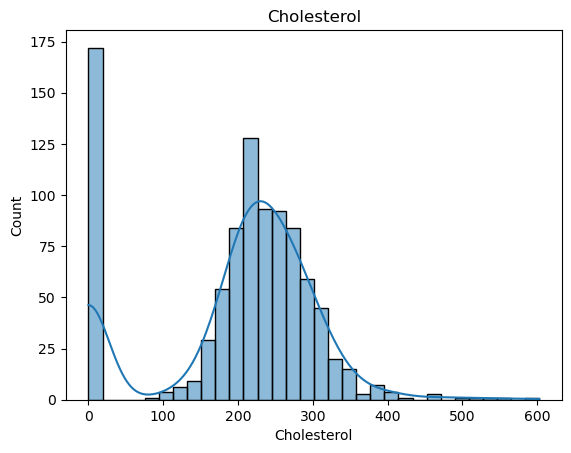

In [2]:
sns.histplot(df_data['Cholesterol'], kde=True)
plt.title("Cholesterol")
plt.show()

Below we need to impute data for the cholesterol as a very large proportion of the entries were 0 and so they have been replaced with the mean.  This just uses a simple imputer, but a KNearestNeighbors algorithm could maybe improve performance of the model later on.

As seen in the second graph the mean value is much higher now, but should prove more useful then keeping nearing 180 values as 0.

In [3]:
from sklearn.impute import SimpleImputer

si = SimpleImputer(missing_values=0, strategy='mean')

df_data['Cholesterol'] = si.fit_transform(df_data[['Cholesterol']])

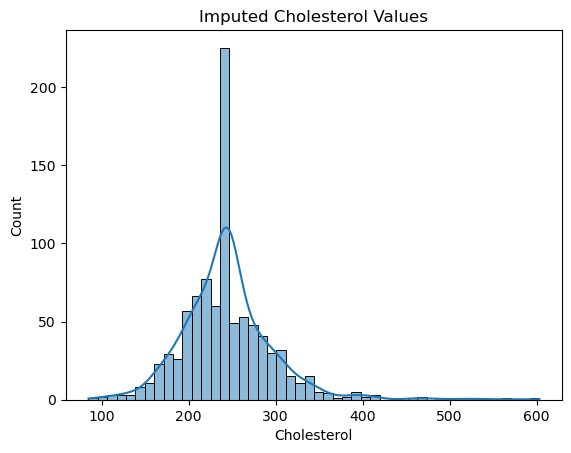

In [4]:
sns.histplot(df_data['Cholesterol'], kde=True)
plt.title("Imputed Cholesterol Values")
plt.show()

## Correlation Map
The graph below shows the correlation of values with each other.  This tells us that for the majority of values, there is little to no correlation amongst really any features.  Heart Disease does show some correlation with Max Heart Rate which is somewhat to be expected as a lower than average heart rate could be a sign of heart disease.

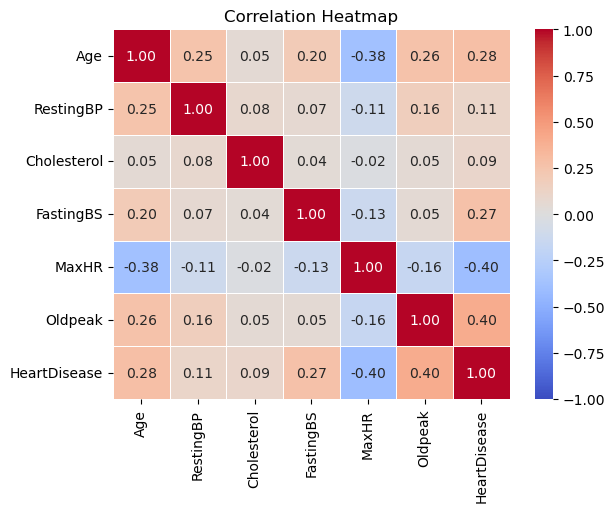

In [5]:
corr_matrix = df_data[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']].corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

## Train Test Split
25% will be used in the testing dataset, and will be stratified so that the testing set has roughly the same amount of Heart Disease and Not Heart Disease characteristics.  We will also apply Standard Scalar and One Hot encoding to features that need it.

In [6]:
from sklearn.model_selection import train_test_split

X, y = df_data.drop(axis=1, columns=['HeartDisease']), df_data['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

ct = ColumnTransformer(
    [
        ('ss', StandardScaler(), ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']),
        ('onehot', OneHotEncoder(), ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])
    ],
    remainder='passthrough'
)

X_train_ct = ct.fit_transform(X_train)
X_test_ct = ct.transform(X_test)

columnNamesCT = ct.get_feature_names_out()

# Turn back into DataFrames
X_train_ct_df = pd.DataFrame(X_train_ct, columns=columnNamesCT)
X_test_ct_df = pd.DataFrame(X_test_ct, columns=columnNamesCT)

## Model Selection

### Linear SVC
A good start for predicting Heart Disease with the given dataset would be to use a LinearSVC model.  We will use a GridSearchCV to make sure that we have optimized parameters and see how it performs using the ROC-AUC metric.

In [8]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

params = {
    'C': [0.0001*10**i for i in range(1, 10)],
    'tol': [0.000000000001*10**i for i in range(1, 10)]
}

clf_linear = LinearSVC(
    random_state=0,
    max_iter=10000,
    dual='auto'
)

gs_clf = GridSearchCV(
    estimator=clf_linear,
    param_grid=params,
    scoring='accuracy',
    n_jobs=-1,
    refit=True,
    cv=10
)

gs_clf.fit(X_train_ct_df, y_train)

print(gs_clf.best_params_)

{'C': 0.1, 'tol': 1e-11}


Accuracy train/test: (0.87/0.85)


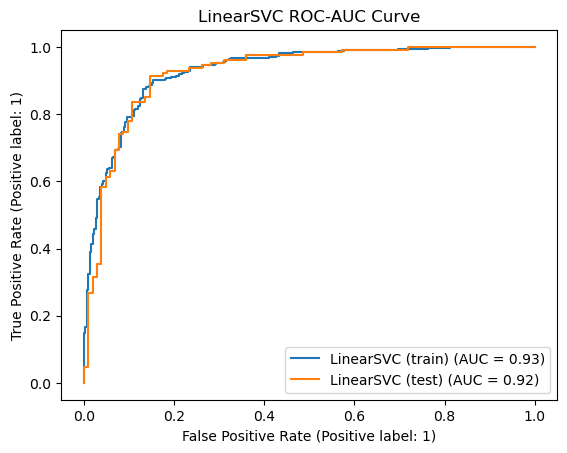

In [9]:
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, gs_clf.predict(X_train_ct_df))
test_acc = accuracy_score(y_test, gs_clf.predict(X_test_ct_df))

print("Accuracy train/test: (%.2f/%.2f)" % (train_acc, test_acc))

lin_disp_train = RocCurveDisplay.from_estimator(gs_clf, X_train_ct_df, y_train, name='LinearSVC (train)', ax=plt.gca())
lin_disp_test = RocCurveDisplay.from_estimator(gs_clf, X_test_ct_df, y_test, name='LinearSVC (test)', ax=plt.gca())
plt.title("LinearSVC ROC-AUC Curve")
plt.show()


### KNearestNeighbors
While LinearSVC had good success, it will still be worth looking at other classifiers.

In [10]:
from sklearn.neighbors import KNeighborsClassifier

params = {
    'n_neighbors': [1+5*i for i in range(1, 10)],
    'leaf_size': [5+5*i for i in range(1, 10)]
}

clf_knn = KNeighborsClassifier(
    n_jobs=-1
)

gs_clf = GridSearchCV(
    estimator=clf_knn,
    param_grid=params,
    scoring='accuracy',
    n_jobs=-1,
    refit=True,
    cv=10
)

gs_clf.fit(X_train_ct_df, y_train)

c:\Users\cgart\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=10, estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'leaf_size': [10, 15, 20, 25, 30, 35, 40, 45, 50],
                         'n_neighbors': [6, 11, 16, 21, 26, 31, 36, 41, 46]},
             scoring='accuracy')

c:\Users\cgart\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
c:\Users\cgart\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


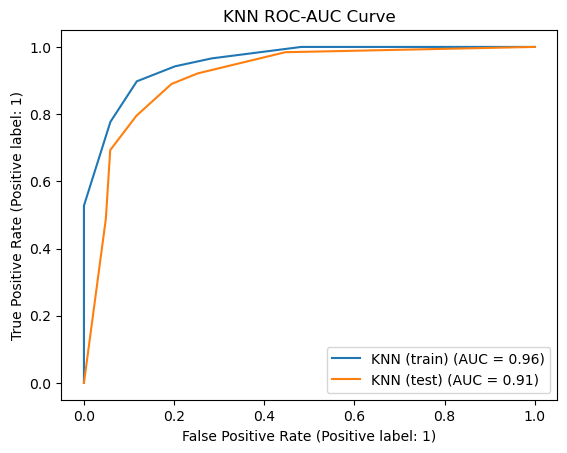

In [12]:
lin_disp_train = RocCurveDisplay.from_estimator(gs_clf, X_train_ct_df.to_numpy(), y_train, name='KNN (train)', ax=plt.gca())
lin_disp_test = RocCurveDisplay.from_estimator(gs_clf, X_test_ct_df.to_numpy(), y_test, name='KNN (test)', ax=plt.gca())
plt.title("KNN ROC-AUC Curve")
plt.show()